In [ ]:
# https://www.youtube.com/watch?v=nuIqwnsrnH0
# https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L11/code/11-eval4-algo__nested-cv_verbose1.ipynb
# https://arxiv.org/abs/1811.12808
# https://www.youtube.com/watch?v=DuDtXtKNpZs

In [1]:
import sys
sys.path.append("/home/rafal/WORK/IMPAN/LocalRegression/")

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import sklearn
import scipy.stats as ss
from pyearth import Earth
import catboost as cb
from BMR.bmr import optimize_min_n_pts, BMR
from BMR.polynomial_regression import PolynomialRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [46]:
def plot_3d_scatter(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.show()

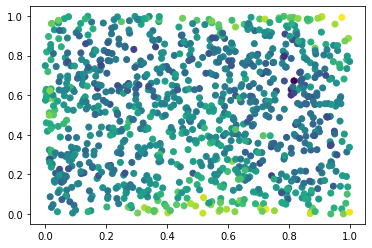

In [55]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [101]:
def Himmelblau(x):
    x = x*10 - 5
    z = (x[:, 0]**2 + x[:, 1] - 11)**2 + (x[:, 0] + x[:, 1]**2 - 7)**2
    z = z/890
    return z
def generate_Himmelblau(n=100, sigma=0.1):
    norm = ss.norm(loc=0, scale=sigma)
    #x = (ss.uniform.rvs(size=(n, 2))-0.5)*5*2
    x = ss.uniform.rvs(size=(n, 2))
    y = Himmelblau(x)
    # scale so that all x points are in [0,1]x[0,1] and all y points are in [0,1]
    #x = (x + 5)/10
    #y = y/890
    if sigma>0:
        y += norm.rvs(n)
    return x, y

In [99]:
X, y = generate_Himmelblau(n=1000)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

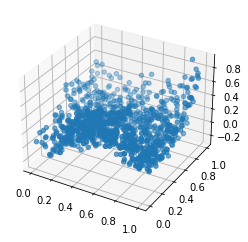

In [100]:
plot_3d_scatter(X, y)

In [143]:
def plot_prediction(model, title, log=False, with_data=True):
    points_per_axis = 25
    my, mx = np.meshgrid(np.linspace(0, 1, points_per_axis), np.linspace(0, 1, points_per_axis))
    mpos = np.vstack([my.ravel(), mx.ravel()]).T
    z = model.predict(mpos).reshape(points_per_axis, points_per_axis)
    z_him = Himmelblau(mpos).reshape(points_per_axis, points_per_axis)
    if log:
        z = np.log(z)
        z_him = np.log(z_him)
    fig, axs = plt.subplots(1,2, figsize=(10,4.5))
    axs[0].contourf(mx, my, z_him, levels=20)
    if with_data:
        axs[0].plot(X_train_val[:, 0], X_train_val[:, 1], 'o', color='white', markersize=1)
    axs[0].set_title('Himmelblau function')
    axs[1].contourf(mx, my, z, levels=20)
    axs[1].set_title(f'{title}')
    plt.show()
    
def evaluate_estimator(pipe, param_grid, cv=5, n_jobs=None):
    gcv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)
    gcv.fit(X_train_val, y_train_val)
    pred = gcv.predict(X_test)
    r2 = r2_score(pred, y_test)
    mae = mean_absolute_error(pred, y_test)
    mse = mean_squared_error(pred, y_test)
    return gcv.best_estimator_, gcv.best_params_, r2, mae, mse, gcv

In [139]:
# Polynomial Regression
label='polynomialregression'
reg_poly = PolynomialRegression()
pipe_poly = Pipeline([('std', StandardScaler()), ('reg', reg_poly)])
param_grid_poly = [{'reg__degree': [1, 2, 3, 4, 5, 6]}]

output_polynomial = evaluate_estimator(pipe_poly, param_grid_poly, cv=5)

MSE: 0.010650193497708613


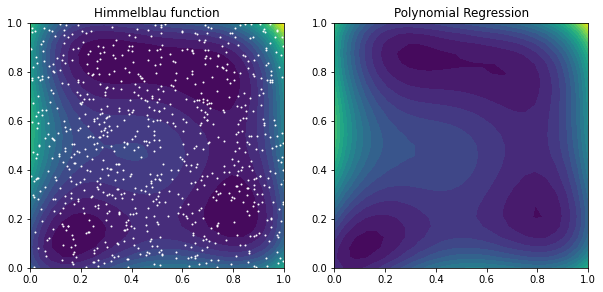

In [156]:
print(f'MSE: {output_polynomial[4]}')
plot_prediction(output_polynomial[0], 'Polynomial Regression')

In [127]:
# SVR
label='SVR'
reg_svr = SVR()
pipe_svr = Pipeline([('std', StandardScaler()), ('reg', reg_svr)])
param_grid_svr = {'reg__degree': [1, 2, 3, 4],
                   'reg__C': [0.1, 1, 3, 5]}
output_svr = evaluate_estimator(pipe_svr, param_grid_svr, cv=5)

MSE: 0.011006151998366322


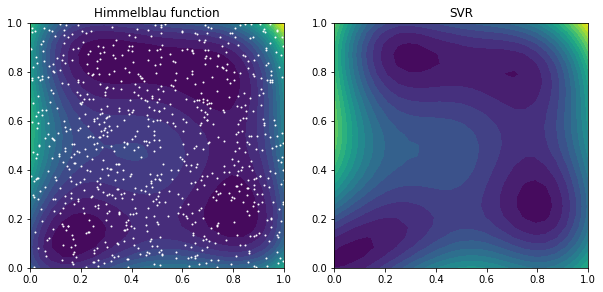

In [155]:
print(f'MSE: {output_svr[4]}')
plot_prediction(output_svr[0], 'SVR')

In [130]:
# MARS
label='MARS'
reg_mars = Earth()
pipe_mars = Pipeline([('std', StandardScaler()), ('reg', reg_mars)])
param_grid_mars = {'reg__max_terms': [None, 1, 2, 3, 4, 5]}
output_mars = evaluate_estimator(pipe_mars, param_grid_mars, cv=5)

MSE: 0.015740374953466064


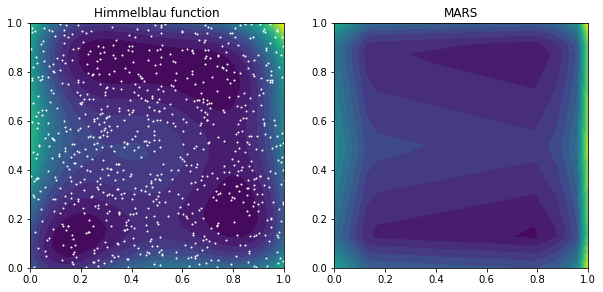

In [154]:
print(f'MSE: {output_mars[4]}')
plot_prediction(output_mars[0], 'MARS')

In [133]:
# RF
label='RF'
reg_rf = RandomForestRegressor()
pipe_rf = Pipeline([('std', StandardScaler()), ('reg', reg_rf)])
param_grid_rf = {'reg__n_estimators': [10, 100, 200, 500]}
output_rf = evaluate_estimator(pipe_rf, param_grid_rf, cv=5, n_jobs=5)

MSE: 0.012239277748617359


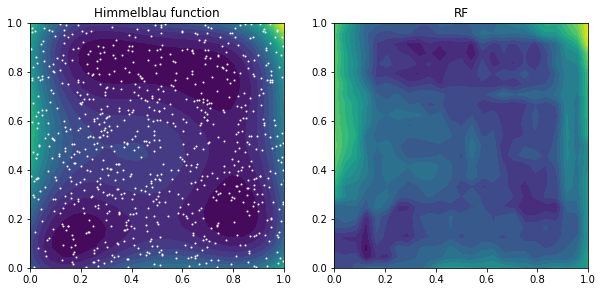

In [153]:
print(f'MSE: {output_rf[4]}')
plot_prediction(output_rf[0], 'RF')

In [136]:
# BMR
label='BMR'
reg_bmr = BMR(epsilon=0.1, min_n_pts=5, M=20)

pipe_bmr = Pipeline([('std', StandardScaler()), ('reg', reg_bmr)])
# param_grid_bmr = {
#     'reg__epsilon': [0.05, 0.1, 0.15, 0.2],
#     'reg__min_n_pt': [4, 6, 8, 10]
# }
param_grid_bmr = {
    'reg__epsilon': [0.3, 0.4, 0.5, 0.6, 0.7],
    'reg__min_n_pt': [10, 12, 15, 17, 20, 25]
}
output_bmr = evaluate_estimator(pipe_bmr, param_grid_bmr, cv=5, n_jobs=5)

MSE: 0.011137967514154934


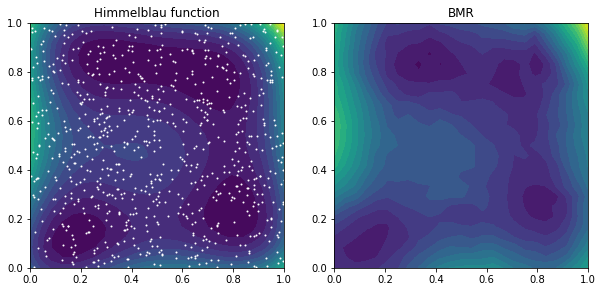

In [152]:
print(f'MSE: {output_bmr[4]}')
plot_prediction(output_bmr[0], 'BMR')